In [13]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from aslib_scenario import ASlibScenario
import copy
import configparser
import database_utils
from scipy.stats import rankdata

In [14]:
np.set_printoptions(precision=3, suppress=True)
good_scenarios = ['CSP-Minizinc-Time-2016', 'MIP-2016','QBF-2016', 'CPMP-2015']
bad_scenarios = ['ASP-POTASSCO', 'MAXSAT12-PMS', 'QBF-2011', 'SAT12-HAND', 'SAT12-ALL']
scenarios = good_scenarios + bad_scenarios
baselines = ['isac','per_algorithm_RandomForestRegressor_regressor','satzilla-11']

In [15]:
def load_configuration():
    config = configparser.ConfigParser()
    config.read_file(open("conf/experiment_configuration.cfg"))
    return config

def fetch_dataframe_from_server(sql_statement):
    db_config = load_configuration()
    db_handle, _ = database_utils.initialize_mysql_db_and_table_name_from_config(db_config)
    table_name = 'MiddleEvaluationView'
    return pd.read_sql(sql_statement, db_handle)


In [16]:
def find_best_approach_for_scenario(df, scenario, metric):
    scenario_df = df[df['scenario_name'] == scenario]
    only_forests = scenario_df[df['approach'] == 'CombinedForest with 100 trees, average_runtimes as consensus, 0.7 of features and mu = 10']
    relevant_metric = only_forests[only_forests['metric'] == metric]
    min_result = relevant_metric['result'].min()
    return only_forests[only_forests['result'] == min_result]

def all_performances_of_approach(df, approach, metric):
    approach  = {key: value[0] for key, value in approach.to_dict('list').items()}
    return df[(df['scenario_name'] == approach['scenario_name']) & (df['approach'] == approach['approach']) & (df['stopping_criteria'] == approach['stopping_criteria']) & (df['metric'] == metric)]
    
def all_depth_of_approach(df, approach, metric):
    df = copy.deepcopy(df)
    approach  = {key: value[0] for key, value in approach.to_dict('list').items()}
    df['stopping_criteria'] = [int((x.split('_')[-1])) if x is not None else None for x in df['stopping_criteria'].to_list()]
    return df[(df['scenario_name'] == approach['scenario_name']) & (df['approach'] == approach['approach']) & (df['impact_factor'] == approach['impact_factor']) & (df['metric'] == metric)].sort_values(by=['stopping_criteria'])

In [17]:
df = fetch_dataframe_from_server("SELECT * FROM MiddleEvaluationView")

In [18]:
scenariowise_lists = {}
for scenario_name in scenarios:
    scenariowise_lists[scenario_name] = {}
    approach = find_best_approach_for_scenario(df, scenario_name, 'par10')
    scenariowise_lists[scenario_name]['Best Hybrid Forest'] = approach['result'].values[0]
    scenariowise_lists[scenario_name]['Best Hybrid Forest stdev'] = approach['stdev'].values[0]
    baseline_df =  df[(df['scenario_name'] == scenario_name) & (df['approach'].isin(baselines)) & (df['metric'] == 'par10')]
    for _,baseline in baseline_df.iterrows():
        scenariowise_lists[scenario_name][baseline['approach']] = baseline['result']
        scenariowise_lists[scenario_name][baseline['approach'] + ' stdev'] = baseline['stdev']
        
        
scores = {'Best Hybrid Forest': 0,  'isac': 0,  'per_algorithm_RandomForestRegressor_regressor': 0,   'satzilla-11': 0, }
for scenario_name in scenarios:
    ranked_list = rankdata([value for key, value in scenariowise_lists[scenario_name].items() if not 'stdev' in key])
    for i, key in enumerate([key for key, value in scenariowise_lists[scenario_name].items() if not 'stdev' in key]):
        if not 'stdev' in key:
            scores [key] += ranked_list[i]/len(scenarios)
 

scenariowise_lists['Average Rank'] = {key:"{:.2f}".format(value) for key, value in scores.items()}


/home/tornede/anaconda3/envs/survival_tests/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/tornede/anaconda3/envs/survival_tests/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/tornede/anaconda3/envs/survival_tests/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/tornede/anaconda3/envs/survival_tests/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid 

In [19]:
for scenario_name in scenariowise_lists.keys():
    if scenario_name == 'Average Rank':
        continue
    keys_without_stdev = [key for key, value in scenariowise_lists[scenario_name].items() if not 'stdev' in key]
    new_values = {}
    for key in keys_without_stdev:
        #new_values[key] = "{:.2f}".format(scenariowise_lists[scenario_name][key]) + r"$\pm$" + "\tab{:.2f}".format(scenariowise_lists[scenario_name][key + ' stdev'])
        new_values[key] = f"{scenariowise_lists[scenario_name][key]:.2f}&$\pm${scenariowise_lists[scenario_name][key + ' stdev']:.2f}"
    scenariowise_lists[scenario_name] = new_values

In [20]:
latex_df = pd.DataFrame(scenariowise_lists).transpose()
latex_df.columns = ['HARRIS', 'ISAC', 'PAR', 'SAT']
print(latex_df.to_latex(escape = False))

\begin{tabular}{lllll}
\toprule
{} &                HARRIS &                  ISAC &                   PAR &                   SAT \\
\midrule
CSP-Minizinc-Time-2016 &    476.97&$\pm$661.60 &   1194.64&$\pm$592.74 &   1044.55&$\pm$886.96 &  1058.08&$\pm$1184.75 \\
MIP-2016               &  1728.82&$\pm$1649.62 &  2975.35&$\pm$3205.29 &  4332.53&$\pm$3320.56 &  2989.38&$\pm$2836.52 \\
QBF-2016               &   1382.08&$\pm$328.42 &   1704.74&$\pm$757.74 &   1722.20&$\pm$836.78 &   1607.81&$\pm$627.32 \\
CPMP-2015              &  4891.47&$\pm$1205.64 &  6094.06&$\pm$1972.29 &  5634.73&$\pm$2181.76 &  5152.87&$\pm$1521.40 \\
ASP-POTASSCO           &     209.47&$\pm$59.07 &    348.57&$\pm$133.53 &     178.81&$\pm$52.20 &     236.48&$\pm$74.78 \\
MAXSAT12-PMS           &    795.44&$\pm$399.61 &   1067.84&$\pm$700.12 &    631.14&$\pm$425.60 &    553.61&$\pm$371.80 \\
QBF-2011               &   2464.69&$\pm$721.31 &  3271.56&$\pm$1270.76 &   1865.75&$\pm$804.27 &   1520.36&$\pm$630.32 \\
SAT

In [21]:
#plt enable latex
#plt.rc('text', usetex=True)

/home/tornede/anaconda3/envs/survival_tests/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/tornede/anaconda3/envs/survival_tests/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/tornede/anaconda3/envs/survival_tests/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/tornede/anaconda3/envs/survival_tests/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid 

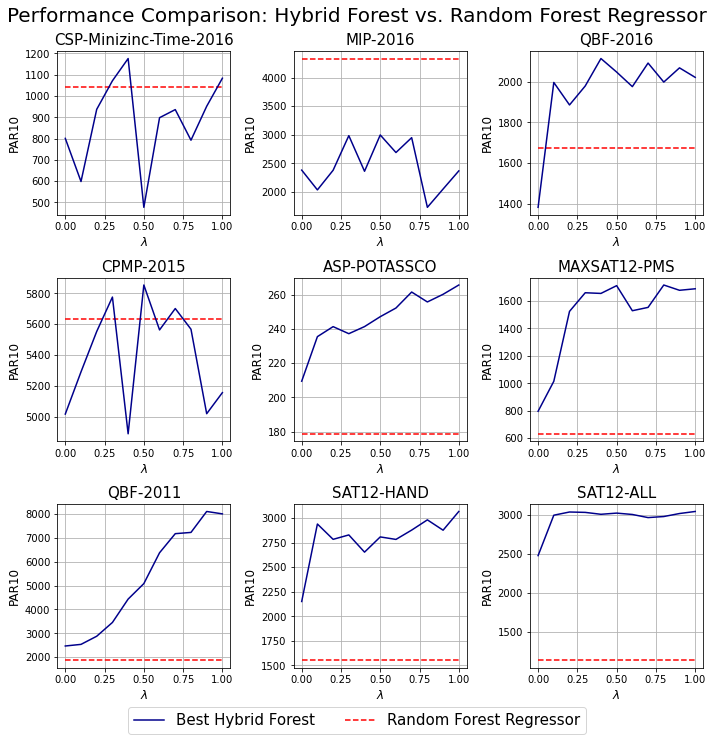

In [28]:
fig, axes = plt.subplots(3, 3, )
axes = axes.flatten()
fig.set_figheight(10)
fig.set_figwidth(10)
fig.set_tight_layout(True)
fig.suptitle('Performance Comparison: Hybrid Forest vs. Random Forest Regressor', fontsize=20)
for scenario_name, axs in zip(scenarios, axes):
	best_hybrid_forest = find_best_approach_for_scenario(df, scenario_name, 'par10')
	all_performances = all_performances_of_approach(df, best_hybrid_forest, 'par10').sort_values(by = 'impact_factor')
	axs.plot(all_performances['impact_factor'].values,all_performances['result'].values, label='Best Hybrid Forest', color = 'darkblue')
	baseline = df[(df['scenario_name'] == scenario_name) & (df['approach'] == 'per_algorithm_RandomForestRegressor_regressor') & (df['metric'] == 'par10')]['result'].values[0]
	axs.set_xlabel(r'$\lambda$', fontsize = 12)
	axs.set_ylabel('PAR10', fontsize = 12)
	axs.set_title(scenario_name, fontsize = 15)
	axs.hlines(baseline,0,1 ,linestyles= '--' , color = 'red',label='Random Forest Regressor')
	axs.grid()
handles, labels = axs.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol = 2, fontsize = 15, bbox_to_anchor=(0.5, -0.04))
fig.savefig('hybrid_vs_random_forest_all.pdf',  bbox_inches='tight')

/home/tornede/anaconda3/envs/survival_tests/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/tornede/anaconda3/envs/survival_tests/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/tornede/anaconda3/envs/survival_tests/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/tornede/anaconda3/envs/survival_tests/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid 

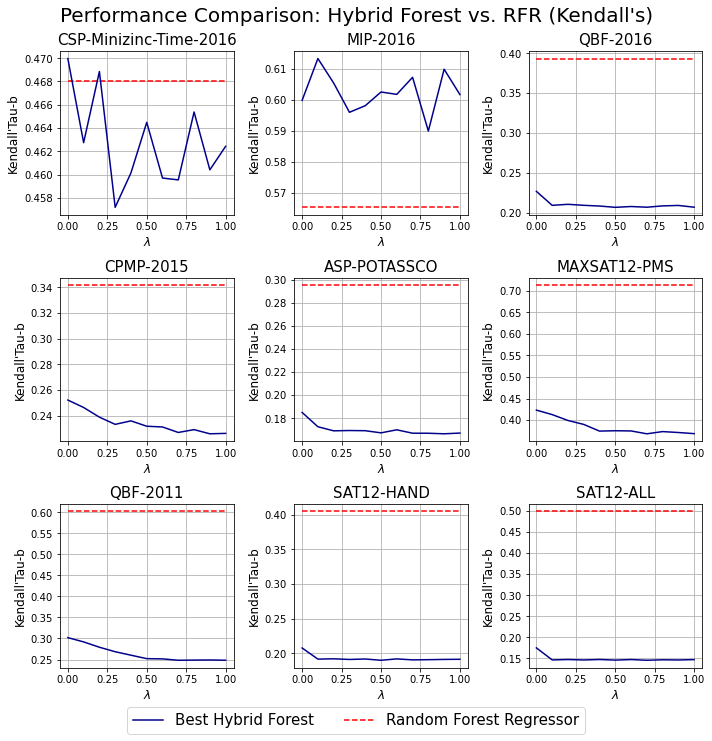

In [32]:
fig, axes = plt.subplots(3, 3, )
axes = axes.flatten()
fig.set_figheight(10)
fig.set_figwidth(10)
fig.set_tight_layout(True)
fig.suptitle('Performance Comparison: Hybrid Forest vs. RFR (Kendall\'s)', fontsize=20)
for scenario_name, axs in zip(scenarios, axes):
	best_hybrid_forest = find_best_approach_for_scenario(df, scenario_name, 'KendallsTau_b')
	all_performances = all_performances_of_approach(df, best_hybrid_forest, 'KendallsTau_b').sort_values(by = 'impact_factor')
	axs.plot(all_performances['impact_factor'].values,all_performances['result'].values, label='Best Hybrid Forest', color = 'darkblue')
	baseline = df[(df['scenario_name'] == scenario_name) & (df['approach'] == 'per_algorithm_RandomForestRegressor_regressor') & (df['metric'] == 'KendallsTau_b')]['result'].values[0]
	axs.set_xlabel(r'$\lambda$', fontsize = 12)
	axs.set_ylabel('Kendall\'Tau-b', fontsize = 12)
	axs.set_title(scenario_name, fontsize = 15)
	axs.hlines(baseline,0,1 ,linestyles= '--' , color = 'red',label='Random Forest Regressor')
	axs.grid()
handles, labels = axs.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol = 2, fontsize = 15, bbox_to_anchor=(0.5, -0.04))
fig.savefig('hybrid_vs_random_forest_all_kendalls.pdf',  bbox_inches='tight')

/home/tornede/anaconda3/envs/survival_tests/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/tornede/anaconda3/envs/survival_tests/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/tornede/anaconda3/envs/survival_tests/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


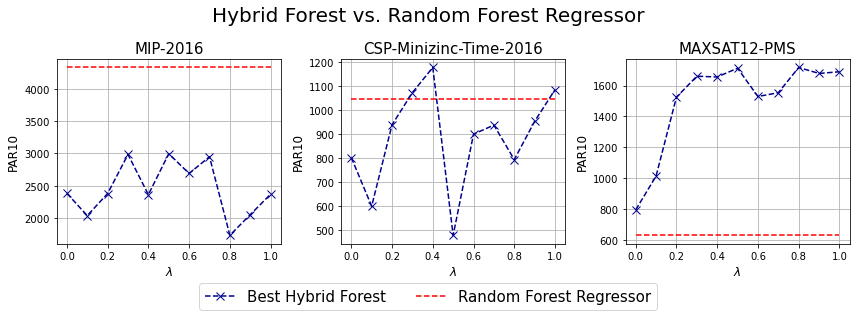

In [23]:
# todo plot one good one bad one middle
#MIP2016
#CSP-Minizinc-Time-2016
#MXASAT12-PMS

fig, axes = plt.subplots(1,3)
axes = axes.flatten()
fig.set_figheight(4)
fig.set_figwidth(12)
fig.set_tight_layout(True)
fig.suptitle('Hybrid Forest vs. Random Forest Regressor', fontsize=20)
for scenario_name, axs in zip(['MIP-2016', 'CSP-Minizinc-Time-2016', 'MAXSAT12-PMS' ], axes):
	best_hybrid_forest = find_best_approach_for_scenario(df, scenario_name, 'par10')
	all_performances = all_performances_of_approach(df, best_hybrid_forest, 'par10').sort_values(by = 'impact_factor')
	axs.plot(all_performances['impact_factor'].values,all_performances['result'].values, label='Best Hybrid Forest', color = 'darkblue', linestyle = '--', marker = 'x', markersize=8)
	baseline = df[(df['scenario_name'] == scenario_name) & (df['approach'] == 'per_algorithm_RandomForestRegressor_regressor') & (df['metric'] == 'par10')]['result'].values[0]
	axs.set_xlabel(r'$\lambda$', fontsize = 12)
	axs.set_ylabel('PAR10', fontsize = 12)
	axs.set_title(scenario_name, fontsize = 15)
	axs.hlines(baseline,0,1 ,linestyles= '--' , color = 'red',label='Random Forest Regressor')
	axs.grid()
handles, labels = axs.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol = 2, fontsize = 15, bbox_to_anchor=(0.5, -0.1))
fig.savefig('hybrid_vs_random_forest.pdf',  bbox_inches='tight')

/home/tornede/anaconda3/envs/survival_tests/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/tornede/anaconda3/envs/survival_tests/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/tornede/anaconda3/envs/survival_tests/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/tornede/anaconda3/envs/survival_tests/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid 

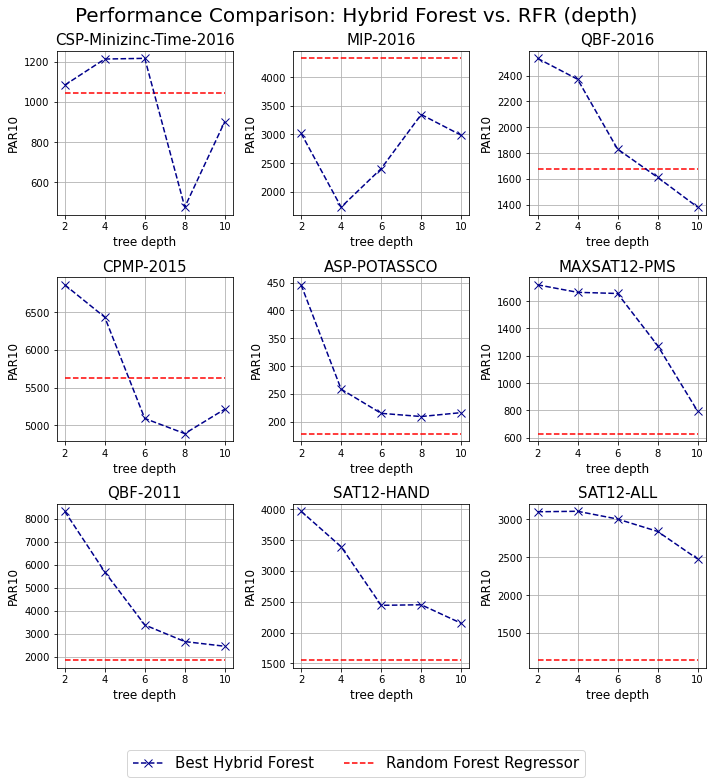

In [27]:
fig, axes = plt.subplots(3, 3, )
axes = axes.flatten()
fig.set_figheight(10)
fig.set_figwidth(10)
fig.set_tight_layout(True)
fig.suptitle('Performance Comparison: Hybrid Forest vs. RFR (depth)', fontsize=20)
for scenario_name, axs in zip(scenarios, axes):
	best_hybrid_forest = find_best_approach_for_scenario(df, scenario_name, 'par10')
	all_performances = all_depth_of_approach(df, best_hybrid_forest, 'par10')
	depths = all_performances['stopping_criteria'].values
	axs.plot(depths,all_performances['result'].values, label='Best Hybrid Forest', color = 'darkblue', linestyle = '--', marker = 'x', markersize=8)
	baseline = df[(df['scenario_name'] == scenario_name) & (df['approach'] == 'per_algorithm_RandomForestRegressor_regressor') & (df['metric'] == 'par10')]['result'].values[0]
	axs.set_xlabel('tree depth', fontsize = 12)
	axs.set_ylabel('PAR10', fontsize = 12)
	axs.set_title(scenario_name, fontsize = 15)
	axs.hlines(baseline,2,10 ,linestyles= '--' , color = 'red',label='Random Forest Regressor')
	axs.grid()
handles, labels = axs.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol = 2, fontsize = 15, bbox_to_anchor=(0.5, -0.1))
fig.savefig('hybrid_depth.pdf',  bbox_inches='tight')